# Pixel Drill for Indices outputs to CSV

| Authors:  | Bex Dunn|
|----------|----------------|
| Created: | March 6, 2019 |
| Last edited: | March 6, 2019 |

**Requirements:**

You need to run the following commands from the command line prior to launching jupyter notebooks from the same terminal so that the required libraries and paths are set:

`module use /g/data/v10/public/modules/modulefiles` 

`module load dea`

If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

__Background:__ Data from the [Landsat](https://landsat.usgs.gov/about-landsat) 5,7 and 8 satellite missions are accessible through [Digital Earth Australia](http://www.ga.gov.au/about/projects/geographic/digital-earth-australia) (DEA).

__What does this notebook do?:__ This notebook takes a supplied CSV of site points. It runs a pixel drill through surface reflectance, calculates NDVI, Taselled cap wetness and greenness, and outputs a csv of values for each site and plots of each index for each site.

**Tags**: :index:`Landsat`,:index:`Landsat5`,:index:`Landsat7`,:index:`Landsat8`, :index:`pixeldrill`, :index:`DEAPlotting`, :index:`datacube.utils.geometry`, :index:`query`,:index:`Scripts`,:index:`tasseled_cap`, :index:`NDVI`,                                                                                                           :index:`DEADataHandling`, :index:`DEAPlotting`, :index:`load_clearlandsat`

import some modules

In [1]:
import datacube
import datetime
import fiona
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio.mask
import rasterio.features
import shapely
import seaborn as sns
import sys
import xarray as xr

import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from datacube.storage import masking
from datacube.utils import geometry

sys.path.append('../10_Scripts')
import DEADataHandling, DEAPlotting, TasseledCapTools, BandIndices

dc = datacube.Datacube(app='pixel drill')

%load_ext autoreload

%autoreload 2

In [ ]:
#set up file to open 

In [ ]:
inpath = '/g/data/r78/rjd547/LTIM_veg_monitoring/LTIM vegetation monitoring sites.csv'

In [2]:
### Convert csv latitude and longitude values into a geopandas geodatafrome

In [21]:
veg_sites = pd.read_csv(inpath, delimiter=",")
#turn csv geometry into geopandas dataframe geometry using lambda functions and shapely
veg_sites['geometry']=veg_sites.apply(lambda z: shapely.geometry.Point(z.LATITUDE, z.LONGITUDE), axis=1)
veg_sites = gpd.GeoDataFrame(veg_sites)

NameError: name 'inpath' is not defined

In [ ]:
#define an output location
output_loc = '/g/data/r78/rjd547/LTIM_veg_monitoring/'

In [ ]:
veg_sites.head(2)

### use a test index to try running this for only one site

In [6]:
test_index=0

In [7]:
query = {'lat':(veg_sites['LATITUDE'][test_index]), 
         'lon':(veg_sites['LONGITUDE'][test_index])}               

In [8]:
Veg_Site = '_'.join(veg_sites['NAME'][test_index].split(' '))
print(Veg_Site)

GWY_MUNG1


In [ ]:
outfilename=output_loc+Veg_Site+'.csv'
print (outfilename)

In [10]:
ls578 = DEADataHandling.load_clearlandsat(dc=dc, query=query, product='nbart')

Loading ls5
    Loading 338 filtered ls5 timesteps
Loading ls7
    Ignoring SLC-off observations for ls7
    Loading 73 filtered ls7 timesteps
Loading ls8
    Loading 131 filtered ls8 timesteps
Combining and sorting ls5, ls7, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


### Calculate NDVI 

### Calculate the tasseled cap indices

In [12]:
#transform the nbart into tci - we want unthresholded, which is why we set drop_tci_bands to False
tci = TasseledCapTools.thresholded_tasseled_cap(ls578,wetness_threshold=-350, drop=True , drop_tc_bands=False)

In [13]:
tcw = tci.wetness
tcg = tci.greenness

In [14]:
ndvi = BandIndices.calculate_indices(ls578, index='NDVI')

The formula we are using is (nir - red)/(nir + red)


create and fill pandas dataframe to write to csv

In [16]:
#drop dimensions of length 1
ndvi = ndvi.squeeze('x')
ndvi = ndvi.squeeze('y')

In [17]:
#make a new dataframe using the data from the xarray of ndvi
NDVI = pd.DataFrame(data=ndvi.data, index=ndvi.time,columns=['ndvi'])

In [18]:
#rename the dataframe so that we can add the other indexes
INDICIES=NDVI

In [19]:
#again drop dims
TCW = tcw.squeeze().data
TCG = tcg.squeeze().data

In [ ]:
# set up final dataframe to write to file 'INDICES'

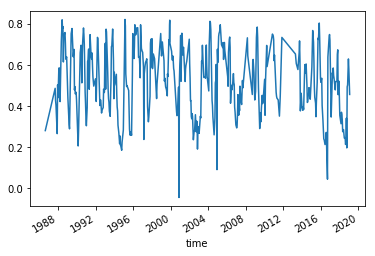

In [25]:
INDICIES['tcw']=TCW
INDICIES['tcg']=TCG
#we have some values where the pixel is cloudy. Drop these values
INDICES = INDICIES.dropna(axis='index', thresh =2)

In [26]:
INDICES.to_csv(outfilename)

In [28]:
!ls /g/data/r78/rjd547/LTIM_veg_monitoring/*.csv

/g/data/r78/rjd547/LTIM_veg_monitoring/GWY_MUNG1.csv
/g/data/r78/rjd547/LTIM_veg_monitoring/LTIM vegetation monitoring sites.csv
/g/data/r78/rjd547/LTIM_veg_monitoring/MDBA_SCA_Tool_uniall_scores.csv


In [29]:
INDICIES.head()

,ndvi,tcw,tcg
time,,,
1986-08-21 23:16:16.500,0.282067,-3263.1508,276.9573
1987-09-09 23:21:35.500,0.488089,-2548.1117,1033.1784
1987-09-25 23:21:58.000,0.428260,-2480.8821,884.0466
1987-10-11 23:22:17.000,0.407141,-3039.4717,766.4563
1987-11-12 23:22:54.500,NaN,NaN,NaN
